# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [2]:
def grab(x):
    return x.detach().cpu().numpy()

In [3]:
def compute_ess(w):
    return (w.mean()**2) / (w**2).mean()

# Phi4 theory

Copied from Lecture 1:

In [4]:
class Phi4Action:
    def __init__(self, m2, lam):
        self.m2 = m2
        self.lam = lam
        self.grad = torch.func.grad(self.value)
    def value(self, phi):
        # phi.shape = (Lx, Ly, ...)
        Nd = len(phi.shape)
        S = ((Nd + self.m2/2) * phi**2 + (self.lam/24) * phi**4).sum()
        for mu in range(Nd):
            phi_fwd = torch.roll(phi, -1, dims=mu)
            S -= (phi * phi_fwd).sum()
        return S

In [5]:
def leapfrog_update(phi, pi, action, *, dt, n_leap):
    phi += (dt/2)*pi
    for _ in range(n_leap-1):
        pi -= dt*action.grad(phi)
        phi += dt*pi
    pi -= dt*action.grad(phi)
    phi += (dt/2)*pi

Modified to keep L as a parameter, and return samples $\phi$ and associated action values:

In [6]:
def run_hmc(action, *, L, n_therm, n_iter, n_meas, dt=0.10, n_leap=10):
    torch.manual_seed(1234)
    phi = 0.1*torch.randn((L, L)) # warm start
    S = action.value(phi)
    acc = 0
    tot = 0
    meas = []
    phis = []
    actions = []
    for i in tqdm.tqdm(range(-n_therm, n_iter)):
        new_phi = phi.clone()
        pi = torch.randn_like(phi)
        K = (pi**2/2).sum()
        leapfrog_update(new_phi, pi, action, dt=dt, n_leap=n_leap)
        Sp = action.value(new_phi)
        Kp = (pi**2/2).sum()
        dH = grab(Sp + Kp - S - K)
        tot += 1
        if np.random.random() < np.exp(-dH): # accept
            phi = new_phi
            S = Sp
            acc += 1
        if i >= 0 and (i+1)%n_meas == 0:
            meas.append(grab(phi.mean()))
            phis.append(grab(phi))
            actions.append(S)
            # print(f'Acc {100.0*acc/tot:.2f}')
    return dict(meas=np.stack(meas), phis=np.stack(phis), actions=np.stack(actions))

# Flow

In [7]:
class Velocity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        conv_kwargs = dict(kernel_size=3, padding=1, padding_mode='circular')
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(2, 8, **conv_kwargs),
            torch.nn.SiLU(),
            torch.nn.Conv2d(8, 8, **conv_kwargs),
            torch.nn.SiLU(),
            torch.nn.Conv2d(8, 1, **conv_kwargs),
        )
        self.jac = torch.func.jacfwd(self.net)
    def value(self, x, t):
        inp = torch.stack([x, torch.ones_like(x)*t])
        return self.net(inp)[0]
    def div(self, x, t):
        shape = x.shape
        x_flat = x.flatten()
        div_b = torch.tensor(0.0)
        def eval_flat(y):
            x = y.reshape(shape)
            inp = torch.stack([x, torch.ones_like(x)*t])
            return self.net(inp)[0].flatten()
        J = torch.func.jacfwd(eval_flat)(x_flat)
        return torch.trace(J)

In [8]:
velocity = Velocity()
phi = torch.randn((4, 4))
print(velocity.value(phi, 1.0))
print(velocity.div(phi, 1.0))

tensor([[ 0.0014,  0.0747, -0.0024,  0.0520],
        [ 0.0745,  0.0423,  0.1191,  0.0836],
        [ 0.0388,  0.0618,  0.1028, -0.0029],
        [ 0.0022,  0.0271, -0.0291,  0.0238]], grad_fn=<SelectBackward0>)
tensor(-0.0998, grad_fn=<TraceBackward0>)


Copied from Lecture 2:

In [9]:
def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.tensor(0.0)
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x = x + sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ = logJ + dt * velocity.div(x, t)
    return x, logJ

In [10]:
# chunk size makes sure we do not try to evaluate all samples at
# the same time, exhausting our memory
flow_batch = torch.func.vmap(flow, in_dims=(0, None), chunk_size=512)
flow_batch(torch.randn((1, 4, 4)), velocity, n_step=10)

(tensor([[[-2.3546, -1.7715,  1.5458, -1.1648],
          [ 0.6422,  0.8166, -1.0610,  0.5190],
          [ 1.6766,  0.5714, -0.0869, -0.6403],
          [-0.0897,  1.6758, -2.1266, -0.4845]]], grad_fn=<CatBackward0>),
 tensor([-0.0922], grad_fn=<CatBackward0>))

  0%|          | 0/1100 [00:00<?, ?it/s]

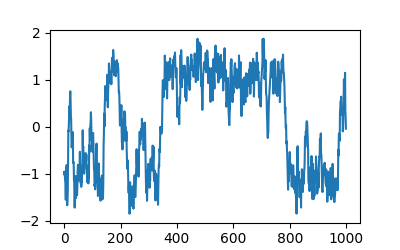

In [11]:
# our target will be in the broken phase
target = Phi4Action(-0.5, 1.5)
res_hmc = run_hmc(target, L=4, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)
fig, ax = plt.subplots(1,1, figsize=(4,2.5))
ax.plot(res_hmc['meas'])
plt.show()

We will approach the target by learning 5 different flows trained to transport between the $m^2 = 0, \lambda = 1.5$ theory (symmetric phase) and the $m^2 = -0.5, \lambda = 1.5$ theory (broken phase) in steps of $m^2$:
$$
(m^2, \lambda) = (0, 1.5) \; \longrightarrow \; (-0.1, 1.5) \; \longrightarrow \; (-0.2, 1.5) \; \longrightarrow \; (-0.3, 1.5) \; \longrightarrow \; (-0.4, 1.5) \; \longrightarrow \; (-0.5, 1.5)
$$

In [12]:
targets = [Phi4Action(m2, 1.5) for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]]

In [51]:
def train_model(prior, target, *, batch_size=4, n_iter=1000):
    torch.manual_seed(1234)
    model = Velocity()
    L = 4
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    loss_hist = []
    ess_hist = []
    flow_batch = torch.func.vmap(flow, in_dims=(0, None))
    target_batch = torch.func.vmap(target.value)
    prior_batch = torch.func.vmap(prior.value)
    res_hmc = run_hmc(prior, L=L, n_therm=100, n_iter=1000, n_meas=1, dt=0.05, n_leap=20)
    prior_samples = res_hmc['phis']
    prior_actions = res_hmc['actions']
    for i in tqdm.tqdm(range(n_iter)):
        opt.zero_grad()
        # sample prior
        inds = np.random.randint(len(prior_samples), size=batch_size)
        xr = torch.tensor(prior_samples[inds])
        logr = -torch.tensor(prior_actions[inds])
        # flow
        x, logJ = flow_batch(xr, model, n_step=10)
        logp = -target_batch(x)
        # ordinary kl logq
        # logq = logr - logJ
        # path grad logq
        model.requires_grad_(False)
        xr2, logJ2 = flow_batch(x, model, n_step=10, inverse=True)
        model.requires_grad_(True)
        logq = -prior_batch(xr2) - logJ2
        # kl div
        loss = (logq - logp).mean()
        loss.backward()
        opt.step()
        loss_hist.append(grab(loss))
        ess = compute_ess((logp - logq).exp())
        ess_hist.append(grab(ess))
        if (i+1) % 25 == 0:
            print(f'Step {i+1}: Loss {grab(loss)} ESS {grab(ess)}')
    fig, axes = plt.subplots(1,2, figsize=(8, 3))
    axes[0].plot(loss_hist)
    axes[1].plot(ess_hist)
    axes[0].set_ylabel('loss')
    axes[1].set_ylabel('ess')
    return dict(model=model, loss=np.stack(loss_hist), ess=np.stack(ess_hist))

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.39178985357284546 ESS 0.9861304759979248
Step 50: Loss -0.35712921619415283 ESS 0.9920380711555481
Step 75: Loss -0.39956894516944885 ESS 0.9907044172286987
Step 100: Loss -0.3753910958766937 ESS 0.9928946495056152
Step 125: Loss -0.38501036167144775 ESS 0.9895044565200806
Step 150: Loss -0.38899752497673035 ESS 0.9925217628479004
Step 175: Loss -0.361349493265152 ESS 0.9917952418327332
Step 200: Loss -0.39167898893356323 ESS 0.9943856000900269


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.4152873456478119 ESS 0.9846137166023254
Step 50: Loss -0.42623406648635864 ESS 0.9789705276489258
Step 75: Loss -0.40991055965423584 ESS 0.9759365320205688
Step 100: Loss -0.4032474756240845 ESS 0.9422230124473572
Step 125: Loss -0.4777993857860565 ESS 0.9736647009849548
Step 150: Loss -0.4631117880344391 ESS 0.9834639430046082
Step 175: Loss -0.4365585446357727 ESS 0.9834809303283691
Step 200: Loss -0.4265916347503662 ESS 0.9871232509613037


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.6224181652069092 ESS 0.9629615545272827
Step 50: Loss -0.5546557903289795 ESS 0.9750178456306458
Step 75: Loss -0.5748244524002075 ESS 0.9714246392250061
Step 100: Loss -0.5320780277252197 ESS 0.9739241600036621
Step 125: Loss -0.45397987961769104 ESS 0.9825394749641418
Step 150: Loss -0.5208141207695007 ESS 0.9635019898414612
Step 175: Loss -0.5564385652542114 ESS 0.9726265668869019
Step 200: Loss -0.5366349816322327 ESS 0.9718473553657532


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.658176064491272 ESS 0.9096723794937134
Step 50: Loss -0.640079140663147 ESS 0.9308043718338013
Step 75: Loss -0.6826944947242737 ESS 0.9436044692993164
Step 100: Loss -0.5904305577278137 ESS 0.9552230834960938
Step 125: Loss -0.7229604125022888 ESS 0.9462592005729675
Step 150: Loss -0.6971028447151184 ESS 0.9301228523254395
Step 175: Loss -0.6378169059753418 ESS 0.9645655751228333
Step 200: Loss -0.7211918234825134 ESS 0.9624138474464417


  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Step 25: Loss -0.873771071434021 ESS 0.9157454371452332
Step 50: Loss -0.8645057678222656 ESS 0.9087120890617371
Step 75: Loss -0.9108566045761108 ESS 0.9026867151260376
Step 100: Loss -0.8422753214836121 ESS 0.892918050289154
Step 125: Loss -0.7866900563240051 ESS 0.9017371535301208
Step 150: Loss -0.8722705245018005 ESS 0.9111911058425903
Step 175: Loss -0.9004049301147461 ESS 0.8966977596282959
Step 200: Loss -0.8461003303527832 ESS 0.8985559940338135


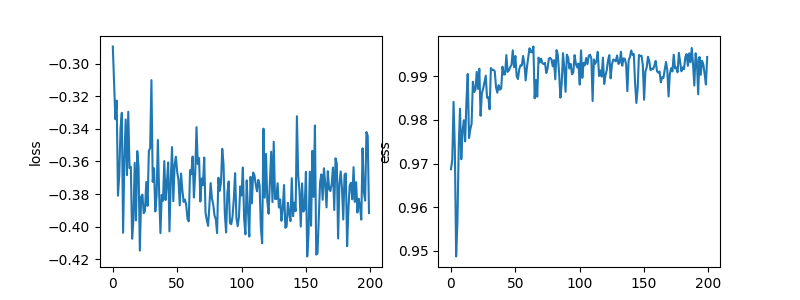

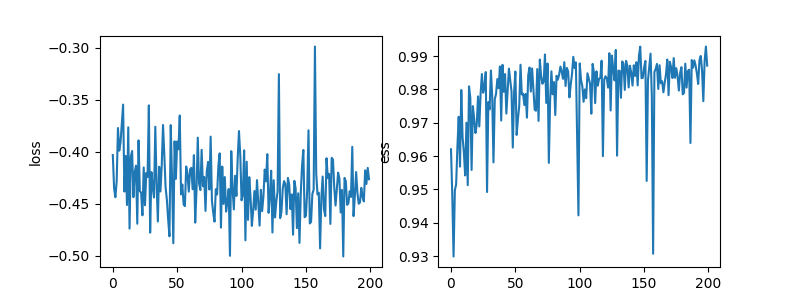

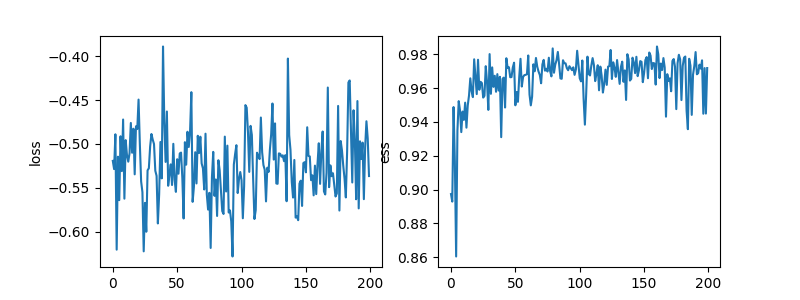

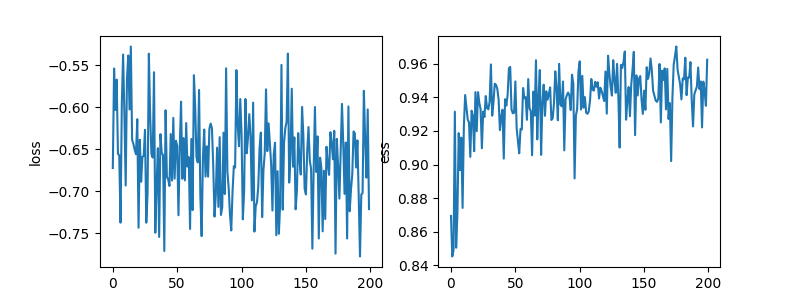

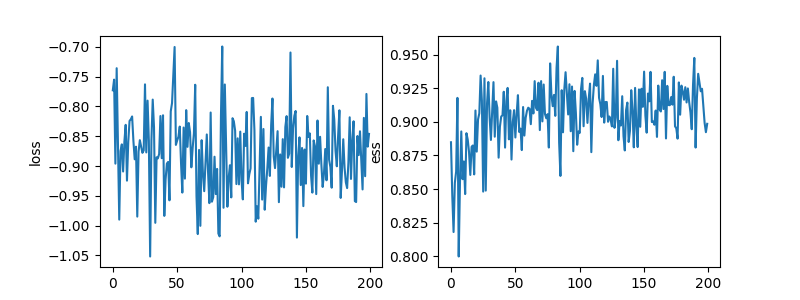

In [14]:
results = [
    train_model(targets[i], targets[i+1], batch_size=32, n_iter=200)
    for i in range(len(targets)-1)
]

# Evaluate

## L = 4

In [15]:
prior = Phi4Action(0.0, 1.5)
phi_r = torch.tensor(run_hmc(prior, L=4, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20)['phis'])
logr = -torch.func.vmap(prior.value)(phi_r)

  0%|          | 0/5100 [00:00<?, ?it/s]

In [44]:
def apply_flows(phi_r):
    samples = [phi_r]
    ws = [torch.ones(phi_r.shape[0])]
    for res, target_p, target in zip(tqdm.tqdm(results), targets[:-1], targets[1:]):
        with torch.no_grad(): # we don't need gradients, so don't waste memory for it
            phi, logJ = flow_batch(samples[-1].clone(), res['model'], n_step=100)
        dlogq = -logJ
        dlogp = -torch.func.vmap(target.value)(phi) + torch.func.vmap(target_p.value)(samples[-1])
        ws.append(ws[-1] * (dlogp - dlogq).exp())
        samples.append(phi)
        print(f'ess: {compute_ess(ws[-1])}')
    return dict(samples=samples, ws=ws)

In [45]:
res_L4 = apply_flows(phi_r)

  0%|          | 0/5 [00:00<?, ?it/s]

ess: 0.9928920269012451
ess: 0.9603358507156372
ess: 0.865261435508728
ess: 0.6767650842666626
ess: 0.45874783396720886


  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

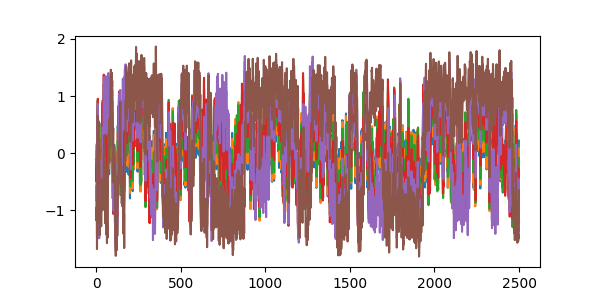

In [17]:
# compare with 2500 samples from the HMC
target = Phi4Action(-0.5, 1.5)
res_hmc_L4 = []
fig, ax = plt.subplots(1,1, figsize=(6, 3))
for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]:
    res_hmc_L4.append(run_hmc(Phi4Action(m2, 1.5), L=4, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20))
    ax.plot(res_hmc_L4[-1]['meas'])
plt.show()

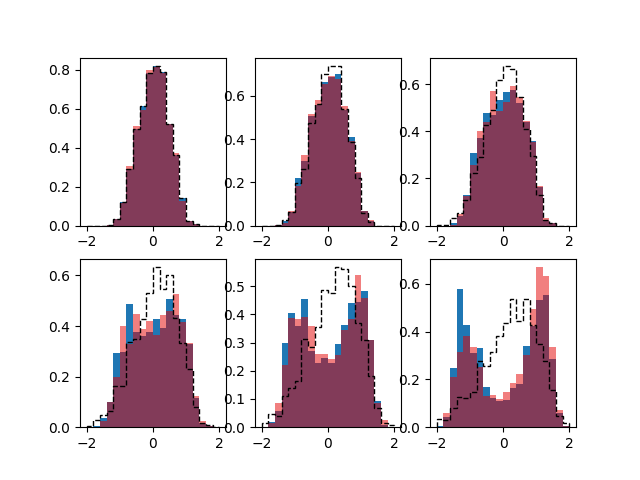

In [50]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, res_hmc in zip(axes, res_L4['samples'], res_L4['ws'], res_hmc_L4):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(res_hmc['meas'], density=True, bins=bins, alpha=0.5, color='xkcd:red')
plt.show()

**EXERCISE:** We will introduce HMC updates between each flow to improve the results. This framework is known as "stochastic normalizing flows".

In [46]:
def apply_stoch_flows(phi_r):
    samples = [phi_r]
    ws = [torch.ones(phi_r.shape[0])]
    for res, target_p, target in zip(tqdm.tqdm(results), targets[:-1], targets[1:]):
        with torch.no_grad(): # we don't need gradients, so don't waste memory for it
            phi, logJ = flow_batch(samples[-1].clone(), res['model'], n_step=100)
        dlogq = -logJ
        dlogp = -torch.func.vmap(target.value)(phi) + torch.func.vmap(target_p.value)(samples[-1])
        ws.append(ws[-1] * (dlogp - dlogq).exp())
        # before saving samples, improve them with an HMC update
        for i in tqdm.tqdm(range(len(phi))):
            new_phi = phi[i].clone()
            pi = torch.randn_like(phi[i])
            S = target.value(phi[i])
            K = (pi**2/2).sum()
            leapfrog_update(new_phi, pi, target, dt=0.05, n_leap=50)
            Sp = target.value(new_phi)
            Kp = (pi**2/2).sum()
            dH = grab(Sp + Kp - S - K)
            if np.random.random() < np.exp(-dH): # accept
                phi[i] = new_phi
        # now, save samples
        samples.append(phi)
        print(f'ess: {compute_ess(ws[-1])}')
    return dict(samples=samples, ws=ws)

In [47]:
res_snf_L4 = apply_stoch_flows(phi_r)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.9928920269012451


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.9771988987922668


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.9366934299468994


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.8468697667121887


  0%|          | 0/2500 [00:00<?, ?it/s]

ess: 0.7305196523666382


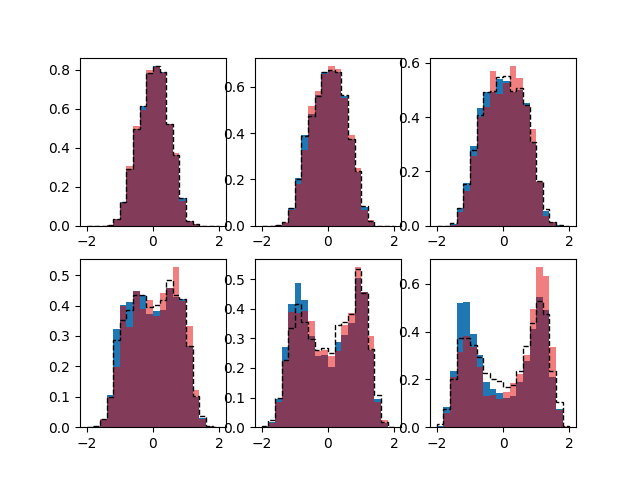

In [49]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, res_hmc in zip(axes, res_snf_L4['samples'], res_snf_L4['ws'], res_hmc_L4):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(res_hmc['meas'], density=True, bins=bins, alpha=0.5, color='xkcd:red')
plt.show()

Conclusion: The ESS is better and the actual distribution of samples after the SNF properly captures the multi-modal distribution!

## L = 8

Because we worked with convolutions, the _same_ flow model can be directly applied to the L=8 theory. The result is not great, but could be improved by scaling up the model, training more, and/or trying to build a specialized model to target the Z2 spontaneous symmetry breaking of the theory.

In [ ]:
prior = Phi4Action(0.0, 1.5)
phi_r = torch.tensor(run_hmc(prior, L=8, n_therm=100, n_iter=5000, n_meas=2, dt=0.05, n_leap=20)['phis'])
logr = -torch.func.vmap(prior.value)(phi_r)

In [ ]:
# reduce number of samples for the sake of time
res_L8 = apply_flows(logr[::10])

In [ ]:
# compare with 250 samples from the HMC
target = Phi4Action(-0.5, 1.5)
res_hmc_L8 = []
fig, ax = plt.subplots(1,1, figsize=(6, 3))
for m2 in [0.0, -0.1, -0.2, -0.3, -0.4, -0.5]:
    res_hmc_L8.append(run_hmc(Phi4Action(m2, 1.5), L=8, n_therm=100, n_iter=1000, n_meas=4, dt=0.05, n_leap=20))
    ax.plot(res_hmc_L8[-1]['meas'])
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 3)
axes = axes.flatten()
bins = np.linspace(-2, 2, 21)
for ax, phi, w, hmc_data in zip(axes, samples, ws, res_hmc_L8):
    ax.hist(grab(phi.flatten(1).mean(-1)), color='k', density=True, histtype='step', bins=bins, linestyle='--')
    ax.hist(grab(phi.flatten(1).mean(-1)), weights=grab(w), density=True, bins=bins)
    ax.hist(hmc_data['meas'], bins=bins, density=True, color='xkcd:red', alpha=0.5)
plt.show()